In [30]:
import os
import urllib.request
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

In [4]:
target_names = df["Label"].unique()

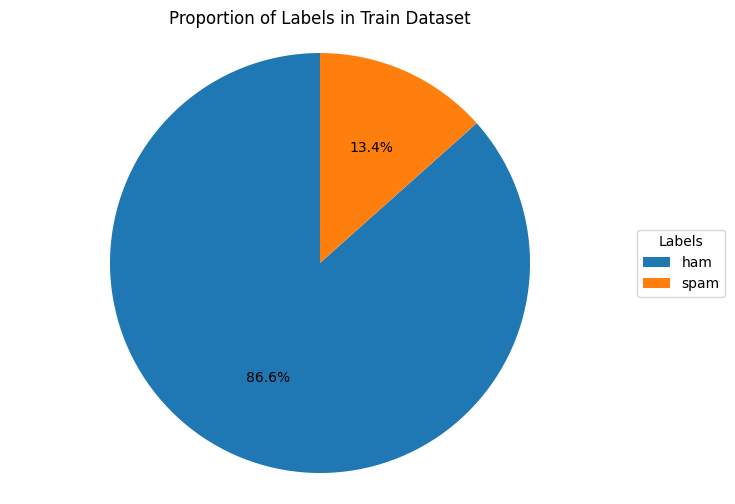

In [5]:
import matplotlib.pyplot as plt
label_counts = df['Label'].value_counts()

fig, ax = plt.subplots(figsize=(8,6))
wedges, texts, autotexts = ax.pie(label_counts, autopct='%1.1f%%', startangle=90)

ax.axis('equal')
ax.set_title('Proportion of Labels in Train Dataset')
ax.legend(wedges, target_names, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [6]:
df[df["Label"] == "spam"]

,Label,Text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [8]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [9]:
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

In [10]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [11]:
CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [12]:
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

In [13]:
from download_wights import download_and_load_gpt2, load_weights_into_gpt

In [16]:
import os
import ipynbname

# Get the full path to the current notebook
notebook_path = ipynbname.path()

# Display the path
print(notebook_path)

/Users/sergeiakhmadulin/Google Drive/My Drive/LLM/Fake_news_GPT.ipynb


In [17]:
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 49.3kiB/s]
/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 927kiB/s]
/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certifica

In [21]:
import Dataset_dataloader as Loader

In [27]:
spam_df = df[df["Label"]=="spam"]["Text"]

In [28]:
train_loader = Loader.create_dataloader_v1(
    tokenizer,
    spam_df,
    batch_size=2,
    max_length=BASE_CONFIG["context_length"],
    stride=BASE_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [24]:
import GPT_manual_architecture as GPT_model
model = GPT_model.GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)

In [39]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss
    
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [31]:
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

In [ ]:
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes
torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

In [33]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [34]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=50256):
    batch_size = idx.size(0)
    finished = torch.zeros(batch_size, dtype=torch.bool, device=idx.device)  # Tracks which sequences are done

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]  # only use last time step

        # Apply top-k filtering
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1].unsqueeze(1)
            logits = torch.where(logits < min_val, torch.full_like(logits, float('-inf')), logits)

        # Temperature sampling
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Update finished sequences
        if eos_id is not None:
            eos_hit = (idx_next == eos_id).squeeze(1)  # (batch,)
            finished = finished | eos_hit  # mark sequences as finished
            if finished.all():
                break  # All sequences have finished

        # Append tokens
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [35]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor
    
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [36]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size,
            top_k=25,
            temperature=1.4
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    # decoded_text = decoded_text.split("<|endoftext|>")[0]
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [37]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()  # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch + 1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [ ]:
import time
start_time = time.time()

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Congrats!", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 7.987, Val loss 7.929
Ep 1 (Step 000005): Train loss 5.188, Val loss 5.037
Ep 1 (Step 000010): Train loss 4.509, Val loss 4.319
Congrats! 1st attempt will get your cash txts, your complimentary colour camera. £350.50
Ep 2 (Step 000015): Train loss 3.895, Val loss 3.968
Ep 2 (Step 000020): Train loss 3.397, Val loss 3.259
Ep 2 (Step 000025): Train loss 3.028, Val loss 2.793
Congrats! 1st week free T&Cs Rply POLYPHONICALLY AWARD! Only 10p per message: Rply shrgxxy420giftk11/10pm-stop. PoBox398x.
Ep 3 (Step 000030): Train loss 2.476, Val loss 2.544
Ep 3 (Step 000035): Train loss 2.148, Val loss 1.977
Ep 3 (Step 000040): Train loss 1.812, Val loss 1.668
Congrats! Uptown Admirer! 1Winaweed!Age16 -18/MobsmoreFrmMob.shp 4 more
Ep 4 (Step 000045): Train loss 1.437, Val loss 1.552
Ep 4 (Step 000050): Train loss 1.102, Val loss 1.119
Ep 4 (Step 000055): Train loss 1.020, Val loss 1.053
Congrats!Win the latest Ringtone from 2004!SKY OPT OUT 08701418720201 PO BOX 3W4